# Project Connect O&M

On October 30th, Project Connect provided a joint meeting of the Austin City Council and its Board of Directors two memos estimating the operations and maintenance (O&M) costs for Bus Rapid Transit (BRT) and Light Rail Transit (LRT) modes serving the alignments commonly referred to as the "Orange" and "Blue" Lines.

This analysis examines the *revenue hour* cost estimates in those memos, as they are the foundation of the overall O&M cost estimate.

There are two main findings: 

- Project Connect's BRT revenue hour cost estimate is lower than the national average by 26%. Project Connect does not explain its rationale for the methodological choices that lead to the lower rate.

- Project Connect's use of a *flat* passenger car revenue hour rate to calculate LRT costs obfuscates the economies of scale associated with multi-car LRT trains. This is a change from the approach taken by Project Connect in 2013-2014. The new method makes Blue Line LRT appear more productive and Orange Line LRT less productive than an approach that recognizes the cost advantages of LRT scale (e.g. multi-car trains). Project Connect does not explain the rationale for the methodological switch or why its current approach will generate more accurate estimates.

The conclusion to this analysis provides several recommendations for Project Connect personnel, as well as local media, and activists.

To provide transparency and clarity about the data and methods used, this analysis is presented as a [Jupyter Notebook](https://jupyter.org/). This format allows for Project Connect vendors, local media, and activists to easily edit, correct, or extend the analysis.

## Setting up our Notebook

Before we get to doing any actual work with data, we have to import the packaged libraries of code that we will use to conduct our analysis. Using already-existing libraries dramatically cuts down on the amount of code one has to write. 

The Python packages we are using are popular and well-documented; they will allows us to efficiently read, organize, and manipulate CSV data, as well as run statistical functions and visualize results.

In [1]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
from scipy.stats import variation
import matplotlib.pyplot as plt
import statsmodels.api as sm

## BRT O&M

The main finding of this review of Project Connect's BRT O&M calculations is that its BRT revenue hour figure is **lower** when compared to the average of the BRT implementations reported in the National Transit Database (NTD).

### Project Connect's BRT Revenue Hour

On page 15 of the October 30th Orange Line O&M memo, Project Connect provides this explanation of their cost estimation methodology:

    Unit costs are given in 2028 dollars, reflecting the anticipated opening date for the Orange Line, and are escalated 3% annually for estimates associated with the 2040 ridership forecast year.

The language on the Orange Line memo leaves the question of whether the batch of 2028 estimates within it are also inflated at the annual 3%. The Blue Line O&M memo is, thankfully, worded in a clearer fashion. Its page 13 explanation removes the doubt:

    Cost calculations are mode-specific and presented in 2028 dollars reflecting the anticipated opening year for the Blue Line Corridor. Unit costs were inflated at three percent annually to 2040. 

In addition to the 3% annual cost inflation constant, the Orange and Blue Line memos provide the following details about the BRT revenue hour figure:

    For new bus and BRT services not covered by the contract, a unit cost of $156.93 per revenue hour (2028) is used as a fully allocated cost (including fuel and general administration). For BRT, an additional cost factor for guideway maintenance is added to the cost per revenue hour. Based on National Transit Database information, an adjustment of $30,000 per directional guideway mile was applied to street-level guideway options. For mixed and elevated guideway options, an annual cost of $80,000 per directional guideway mile was used.

The language implies that the Project Connect team is using a current, contractually-negotiated set of numbers for the three expense categories the 2018 and 2019 NTD Full Reporting Policy Manuals label as "vehicle operations", "vehicle maintenance", and "general administration". And then Project Connect switches to using NTD products to figure out the guideway maintenance, which is typically included under the NTD operating expense reporting category labeled as "non-vehicle maintenance".

Unfortunately, it is not clear what method was used to calculate the $156.93 number.

The Orange Line memo includes a set of tables under Appendix A on page 16. The 2028 O&M Cost Calculations in that table report the vehicle revenue hours and total annual operating expenses under two guideway options. The figures are 173,000 revenue hours and $30,249,000 cost for the elevated option. It's 148,000 revenue hours and $24,399,000 cost for the surface option.

Let's calculate the actual 2028 revenue hour cost including the guideway maintenance.


In [2]:
brt_revenue_hour_28_elevated = 30_249_000 / 173_000
brt_revenue_hour_28_surface = 24_399_000 / 148_000
print('BRT Elevated Option Revenue Hour (2028): ${:.2f}'.format(brt_revenue_hour_28_elevated))
print('BRT Surface Option Revenue Hour (2028): ${:.2f}'.format(brt_revenue_hour_28_surface))

BRT Elevated Option Revenue Hour (2028): $174.85
BRT Surface Option Revenue Hour (2028): $164.86


Now, let's change those 2028 dollars to 2017 dollars (the NTD data year used by Project Connect) using the 3% annual rate identified in their methodology narrative.

In [3]:
brt_revenue_hour_17_elevated = brt_revenue_hour_28_elevated / (1.03 ** 11)
brt_revenue_hour_17_surface = brt_revenue_hour_28_surface / (1.03 ** 11)
print('BRT Elevated Option Revenue Hour (2017): ${:.2f}'.format(brt_revenue_hour_17_elevated))
print('BRT Surface Option Revenue Hour (2017): ${:.2f}'.format(brt_revenue_hour_17_surface))

BRT Elevated Option Revenue Hour (2017): $126.32
BRT Surface Option Revenue Hour (2017): $119.10


### NTD's BRT Revenue Hour

Are Project Connect's \\$126 and \\$119 revenue hour costs for 2017 correct?

To double-check whether those numbers make sense, we will utilize the available 2017 BRT data from the NTD. 

Specifically, we transform the 2017 operating expense and service data Excel spreadsheets accessible by the [NTD Data Reports download page](https://www.transit.dot.gov/ntd/ntd-data) into easier to consume CSV files accessible through this site.

To begin our BRT revenue hour review, we load two CSVs of 2017 NTD operating data. 

The first CSV file includes the vehicle revenue hours for each agency and mode for 2017. The second CSV file includes the *total* operating expenses for each agency and mode. As discussed above, the *total* operating expense amounts include non-vehicle maintenance, such as guideway maintenance.

You'll start to see the letters "df" quite a bit at this point in the Notebook. They are used to help the reader understand that the variable is a DataFrame. For those of you unfamiliar with dataframes/Python data science tools, think of a dataframe as something similar to a spreadsheet or an Excel Worksheet. A dataframe, like an Excel Worksheet, is used to represent and efficiently work with rows and columns of data. 

Once the data files are loaded, we make a query to select only the data for operating Bus Rapid Transit modes. NTD uses the initials `RB` to label the BRT mode. 

We do some column name cleanup to facilitate legibility and then we merge the vehicle revenue hours (VRH) and operating expenses (OPEX) data sets. This allows us to create a new column providing the 2017 Revenue Hour Cost.

In [4]:
vehicle_revenue_hour_df = pd.read_csv('ntd_vrh_2017.csv')
opex_df = pd.read_csv('ntd_total_opex_2017.csv')
brt_vehicle_revenue_hour_df = vehicle_revenue_hour_df.query("Mode=='RB' & `Mode Status` == 'Operating'")
brt_vehicle_revenue_hour_df = brt_vehicle_revenue_hour_df.rename(columns={'2017': '2017 VRH'})
brt_opex_df = opex_df.query("Mode=='RB' & `Mode Status` == 'Operating'")
brt_opex_df = brt_opex_df.rename(columns={'2017': '2017 OPEX'})
bare_brt_opex_df = brt_opex_df[['NTD ID', 'Service', '2017 OPEX']].copy()
brt_df = pd.merge(brt_vehicle_revenue_hour_df, bare_brt_opex_df, on=['NTD ID', 'Service'])
brt_df['Revenue Hour Cost'] = brt_df['2017 OPEX'] / brt_df['2017 VRH']
brt_df[['Agency Name', 'City', '2017 OPEX', '2017 VRH', 'Revenue Hour Cost']]

,Agency Name,City,2017 OPEX,2017 VRH,Revenue Hour Cost
0,Lane Transit District(LTD),Eugene,6463202.0,37929.0,170.402647
1,Massachusetts Bay Transportation Authority(MBTA),Boston,18489929.0,125579.0,147.237428
2,Connecticut Department of Transportation - CTT...,Hartford,9105566.0,41851.0,217.571050
3,MTA New York City Transit(NYCT),New York,99445139.0,527568.0,188.497291
4,Central Florida Regional Transportation Author...,Orlando,3290958.0,46974.0,70.059139
5,The Greater Cleveland Regional Transit Authori...,Cleveland,6161689.0,67204.0,91.686343
6,Interurban Transit Partnership(The Rapid),Grand Rapids,2098600.0,27793.0,75.508221
7,Kansas City Area Transportation Authority(KCATA),Kansas City,5637075.0,44835.0,125.729341
8,Transfort,Fort Collins,3115771.0,30069.0,103.620706
9,Roaring Fork Transportation Authority,Westcliffe,8506328.0,69681.0,122.075286


As of the 2017 NTD, there are 11 agencies running BRT. 

Interestingly, Project Connect predicts just the Orange Line's required vehicle revenue hours in 2028 will already exceed the 2017 BRT vehicle revenue hour amounts of each *agency* except New York's MTA. 

Here's what we get as the national average of all revenue hours and costs across the 11 agencies for 2017.

In [5]:
national_brt_revenue_hour_avg = brt_df['2017 OPEX'].sum() / brt_df['2017 VRH'].sum()
print('National BRT revenue hour average (2017): ${:.2f}'.format(national_brt_revenue_hour_avg))

National BRT revenue hour average (2017): $170.28


The \\$170 (2017) national average is higher than Project Connect's upper estimate of \\$126 (2017). Project Connect's revenue hour estimate is 26% lower than the national average.

As indicated above, while the Project Connect team detailed *how* they created their revenue hour estimate, it didn't explain *why* it made the choices it did relative to just selecting the national average. 

One argument against using the national average is that there are no natural peers in the NTD BRT data. There are no Sun Belt or non-coastal agencies that are running the scale of BRT revenue hours envisioned by Project Connect for the Orange and Blue Lines. On the other hand, the systems running a lot of BRT hours have the higher per hour costs. 

There might be unforeseen vehicle and non-vehicle maintenance costs when true BRT is used at levels not presently experienced by CapMetro. Simply asserting a revenue hour estimate without establishing its validity undermines quality decision-making by policymakers.

## LRT O&M

The main finding of this review of Project Connect's LRT O&M calculations is that it obscures the scaling advantages of LRT. 

This undermines the productivity of Orange Line LRT, while inflating that of Blue Line LRT.

### Project Connect's LRT Revenue Hour

On page 15 of the October 30th Orange Line O&M memo, Project Connect provides the following explanation for their LRT revenue hour cost:

    O&M unit costs for LRT service reflect a weighted national average cost per revenue hour of $393.33 (2028, adjusted from $284.15 2017 NTD). This includes guideway maintenance.
    
The Blue Line LRT estimates use the same method. The 3% annual inflation constant is also used.

One important decision that Project Connect's new methodology makes is that it views each passenger car in a train as a "vehicle" with a fixed cost. 

So, the third car on the train costs as much as the first one. 

During the 2013-14 version of Project Connect, its vendors used a [different methodology](http://keepaustinwonky.org) that recognized fixed system costs, train costs, and passenger car costs. 

We'll discuss this choice and its implications in more detail below.

### NTD's LRT Revenue Hour

Is the $284.15 revenue hour cost for 2017 correct?

To check Project Connect's number, we will use the available 2017 LRT data from the NTD. 

Again, we transform the 2017 operating expense and service data Excel spreadsheets accessible by the [NTD Data Reports download page](http://www.transit.dot.gov/ntd/ntd-data) into easier to consume CSV files accessible through this site.

We already loaded the necessary data to conduct the above BRT analysis, so we query to select only the data for operating LRT modes, and then do the same data cleanup and merging as we did with the BRT section above. 

In [6]:
lrt_vehicle_revenue_hour_df = vehicle_revenue_hour_df.query("Mode=='LR' & `Mode Status` == 'Operating'")
lrt_vehicle_revenue_hour_df = lrt_vehicle_revenue_hour_df.rename(columns={'2017': '2017 VRH'})
lrt_opex_df = opex_df.query("Mode=='LR' & `Mode Status` == 'Operating'")
lrt_opex_df = lrt_opex_df.rename(columns={'2017': '2017 OPEX'})
bare_lrt_opex_df = lrt_opex_df[['NTD ID', 'Service', '2017 OPEX']].copy()
lrt_df = pd.merge(lrt_vehicle_revenue_hour_df, bare_lrt_opex_df, on=['NTD ID', 'Service'])
lrt_df['Revenue Hour Cost'] = lrt_df['2017 OPEX'] / lrt_df['2017 VRH']
lrt_df[['Agency Name', 'City', 'Service', '2017 OPEX', '2017 VRH', 'Revenue Hour Cost']]

,Agency Name,City,Service,2017 OPEX,2017 VRH,Revenue Hour Cost
0,Tri-County Metropolitan Transportation Distric...,Portland,DO,138797386.0,623791.0,222.506234
1,Central Puget Sound Regional Transit Authority...,Seattle,DO,91194100.0,251376.0,362.779661
2,Massachusetts Bay Transportation Authority(MBTA),Boston,DO,187119893.0,668402.0,279.951127
3,Niagara Frontier Transportation Authority(NFT ...,Buffalo,DO,23862248.0,82845.0,288.034860
4,New Jersey Transit Corporation(NJ TRANSIT),Newark,DO,19726085.0,51556.0,382.614730
5,New Jersey Transit Corporation(NJ TRANSIT),Newark,PT,92685527.0,123198.0,752.329802
6,Port Authority of Allegheny County(Port Author...,Pittsburgh,DO,62950866.0,169646.0,371.071914
7,Maryland Transit Administration(MTA),Baltimore,DO,42626110.0,157002.0,271.500427
8,Transportation District Commission of Hampton ...,Hampton,DO,11609880.0,29868.0,388.706308
9,Charlotte Area Transit System(CATS),Charlotte,DO,14291472.0,66641.0,214.454645


In [7]:
national_lrt_revenue_hour_avg = lrt_df['2017 OPEX'].sum() / lrt_df['2017 VRH'].sum()
print('National LRT revenue hour average (2017): ${:.2f}'.format(national_lrt_revenue_hour_avg))

National LRT revenue hour average (2017): $286.17


The calculated national LRT revenue hour average of \\$286.17 is virtually identical to Project Connect's \\$284.15.

Unlike BRT, though, there is a set of communities that could arguably be seen as more closely resembling central Texas' labor policy and business costs, and therefore serve as a more accurate proxy for this region's likely O&M costs. During the 2013-2014 version of Project Connect, their methodology used a peer subset to calculate LRT O&M costs.

Specifically, Houston, Denver, Salt Lake City, Dallas, Charlotte, and Phoenix are all non-coastal communities with labor, state policy and business cost drivers that are perceived by many as more similar to Austin's that the main West Coast metros or Northeast cities. 

Let's see what the peer city LRT revenue hour looks like.

In [8]:
peer_cities = {'Houston', 'Denver', 'Salt Lake City', 'Dallas', 'Charlotte', 'Phoenix'}
peer_lrt_df = lrt_df[lrt_df['City'].isin(peer_cities)]
peer_lrt_revenue_hour_avg = peer_lrt_df['2017 OPEX'].sum() / peer_lrt_df['2017 VRH'].sum()
national_lrt_variation = variation(lrt_df['Revenue Hour Cost'])
peer_lrt_variation = variation(peer_lrt_df['Revenue Hour Cost'])
print('Peer city LRT revenue hour average (2017): ${:.2f}'.format(peer_lrt_revenue_hour_avg))
print('Peer city LRT revenue hour discount factor (2017): {}'.format(peer_lrt_revenue_hour_avg / national_lrt_revenue_hour_avg))
print('National LRT revenue hour coefficient of variation: {}'.format(national_lrt_variation))
print('Peer city LRT revenue hour coefficient of variation: {}'.format(peer_lrt_variation))



Peer city LRT revenue hour average (2017): $210.31
Peer city LRT revenue hour discount factor (2017): 0.7349138441935215
National LRT revenue hour coefficient of variation: 0.43697372476675667
Peer city LRT revenue hour coefficient of variation: 0.3293199499498427


As expected, the peer city LRT is lower at \\$210.31 (2017), with the peer city average revenue hour representing 76% of the national average revenue hour cost.

The peer city revenue hour cost estimates have a lower [coefficient of variation](https://en.wikipedia.org/wiki/Coefficient_of_variation) (a common measure of dispersion) than the entire national LRT data set. 

Why does this matter? A reasonable argument against using a smaller data set of peer cities to select the revenue hour cost figure would be to raise concern about how dramatic outliers could easily distort the average. That the peer city data has a smaller coefficient of variation than the complete LRT data set addresses the outlier concern.

### Train vs. Car

NTD's Full Reporting Policy Manuals and its actual database make a distinction between a light rail *train* revenue hour and a passenger *car* revenue hour. As explained above, a train can have one or more cars. 

Why would NTD collect car *and* train data if a flat passenger car revenue hour is the superior budgeting metric, as Project Connect assumes in its October 30th O&M memos? Why would they track train hours?

There are several reasons, but one of them is the perceived scaling advantage of light rail. From an O&M perspective, a common perception shared by some industry professionals and transit advocates is that the fixed expenses associated with fielding a train with one car (e.g. the train operator) can be shared by additional cars. The implication is that the cost of serving an additional rail customer with light rail keeps going down as passenger cars are added. 

This is different than BRT, which must field an additional vehicle with, for example, an additional driver. With BRT, the "train" always has one "car".

So, are the perceived advantages of rail at scale real or is it just theory?

Let's dive into this question by loading a new data set that includes *train* revenue hours. In this data set, an individual agency can have data associated with the light rail services it directly operates ("DO" service type) or that it pays for and does not directly operate ("PT" service type).

We'll do some cleanup on the column names and drop the Hudson-Bergen light rail as it is an outlier data point with a much, much higher cost structure and it is not directly operated by a transit agency. And we'll merge the new train data with the already loaded agency operating expense data. We also mark the peer cities discussed above with a [dummy variable](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)).

After some basic calculations, there are four new columns for each agency's service implementation. 

*Extra Car Revenue Hours* finds the difference between train revenue hours and vehicle revenue hours, which indicates the count of revenue hours produced by the cars operated in addition to the first train car. 

The *Load Factor* divides the total vehicle revenue hours by the train revenue hours; this helps us determine the average number of cars for a train.

*Train RevHr Opex* divides the total 2017 operating expenses by *train* revenue hours. This provides an estimate of what the average LRT train costs to run for each agency service type.

*Car RevHr Opex* divides the total 2017 operating expenses by vehicle revenue hours. A "vehicle" is a passenger car according to the NTD reporting manual. This column reports the average LRT car costs to run for each agency service type. 

We sort the data table by load factor in ascending order.

In [9]:
service_df = pd.read_csv('ntd_service_2017.csv')
rail_df = service_df.query("Mode=='LR'").copy()
rail_df = rail_df.rename(columns={'Train \nRevenue \nHours': 'Train Revenue Hrs', 
                                  'Vehicle \nRevenue \nHours': 'Vehicle Revenue Hrs',
                                  'Type of Service': 'Service'})
rail_df = rail_df.drop(rail_df[(rail_df['Service'] == 'PT') & (rail_df['City'] == 'Newark')].index)
rail_df['Extra Car Revenue Hrs'] = rail_df['Vehicle Revenue Hrs'] - rail_df['Train Revenue Hrs']
rail_df['Load Factor'] = rail_df['Vehicle Revenue Hrs'] / rail_df['Train Revenue Hrs']
rail_df['NTD ID'] = rail_df['NTD ID'].astype(int)
rail_economics_df = pd.merge(rail_df, bare_lrt_opex_df, on=['NTD ID', 'Service'])
peer_cities = {'Houston', 'Denver', 'Salt Lake City', 'Dallas', 'Charlotte', 'Phoenix'}
rail_economics_df['Peer'] = np.where(rail_economics_df['City'].isin(peer_cities), 1, 0)
rail_economics_df['Train RevHr Opex'] = rail_economics_df['2017 OPEX'] / rail_economics_df['Train Revenue Hrs']
rail_economics_df['Car RevHr Opex'] = rail_economics_df['2017 OPEX'] / rail_economics_df['Vehicle Revenue Hrs']
rail_economics_df[['Name', 'City', 'Peer', 'Service', 'Train Revenue Hrs', 'Vehicle Revenue Hrs', 'Extra Car Revenue Hrs', 'Train RevHr Opex', 'Car RevHr Opex', 'Load Factor']].sort_values(by=['Load Factor'])

,Name,City,Peer,Service,Train Revenue Hrs,Vehicle Revenue Hrs,Extra Car Revenue Hrs,Train RevHr Opex,Car RevHr Opex,Load Factor
0,New Jersey Transit Corporation,Newark,0,DO,51556,51556,0,382.614730,382.614730,1.000000
18,Transportation District Commission of Hampton ...,Hampton,0,DO,29868,29868,0,388.706308,388.706308,1.000000
14,The Greater Cleveland Regional Transit Authority,Cleveland,0,DO,50272,50655,383,253.459500,251.543105,1.007619
8,San Francisco Municipal Railway,San Francisco,0,DO,395030,579417,184387,541.157699,368.945899,1.466767
3,Metropolitan Transit Authority of Harris Count...,Houston,1,DO,194682,287042,92360,334.744542,227.035545,1.474415
10,Port Authority of Allegheny County,Pittsburgh,0,DO,114991,169646,54655,547.441678,371.071914,1.475298
13,Santa Clara Valley Transportation Authority,San Jose,0,DO,139433,217434,78001,760.343749,487.582485,1.559416
2,Massachusetts Bay Transportation Authority,Boston,0,DO,388003,668402,280399,482.264037,279.951127,1.722672
4,Maryland Transit Administration,Baltimore,0,DO,87951,157002,69051,484.657480,271.500427,1.785108
7,Dallas Area Rapid Transit,Dallas,1,DO,268769,491854,223085,651.852956,356.198927,1.830025


As the table demonstrates, some agencies are deploying light rail exclusively with one-car trains, while others *average* almost 3 cars per train. 

If rail does indeed have scale advantages, then we would expect that the car revenue hour cost for systems with high load factors would tend to be lower. Certainly, regional variations in labor policy and business costs, along with other complicating factors such as geography, will also contribute to the variation in car revenue hours costs. But give that cost-competitiveness at scale is an oft-cited advantage of light rail, one would still expect additional cars to be more cost effective as trains get longer.

Let's check if the basic "rail scales" correlation exists by comparing the *Car Revenue Hour Opex* (y-axis) for each agency against its *Load Factor* (x-axis). We'll use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) method.

                Car RevHr Opex  Load Factor
Car RevHr Opex        1.000000    -0.456663
Load Factor          -0.456663     1.000000


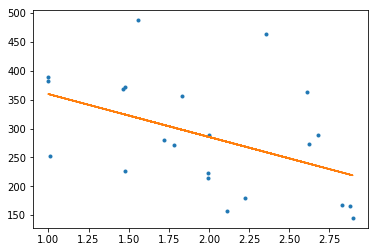

In [10]:
corr_df = rail_economics_df[['Car RevHr Opex', 'Load Factor']].copy()
print(corr_df.corr())
vis_x = rail_economics_df['Load Factor']
vis_y = rail_economics_df['Car RevHr Opex']
b, m = polyfit(vis_x, vis_y, 1)
plt.plot(vis_x, vis_y, '.')
plt.plot(vis_x, b + m * vis_x, '-')
plt.show()

The calculation results and accompanying visualization show that there is indeed a negative correlation. By convention, most statisticians/analysts will describe a correlation of -0.46 as "moderate", with -0.51 being the threshold for a "strong" negative correlation. However, given the many other factors that contribute to costs, this is a solid finding in favor of the "rail scales" argument.

One challenge that the Project Connect team likely faced when deciding on an O&M cost calculation methodology was how to split costs between fixed operating system expenses that have to be paid before even the first train runs, the expenses for the first car of a train, and the expenses of each additional train car. By opting for a flat per car revenue hour measure, this discussion was simplified for policymakers. Unfortunately, as the national LRT vehicle revenue hour coefficient of variation demonstrates, the flat rate method would miss the actual reported rates for most systems by substantial amounts.

To arrive at a less risky O&M cost estimate with more nuanced cost allocation, we'll use [ordinary least squares linear regression](http://setosa.io/ev/ordinary-least-squares-regression/) as an exploratory tool in finding a more accurate cost distribution. The dependent variable (i.e. the outcome) in the regression will be the total operating expense for each agency LRT service type. We will use train revenue hours, extra car revenue hours, and the peer dummy variable as the independent variables (i.e. the outcome drivers).

In [11]:
model = sm.OLS(rail_economics_df['2017 OPEX'], 
               sm.add_constant(rail_economics_df[['Train Revenue Hrs', 'Extra Car Revenue Hrs', 'Peer']]))
results = model.fit()
summary = results.summary()
print(summary.tables[0])
print(summary.tables[1])

                            OLS Regression Results                            
Dep. Variable:              2017 OPEX   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     18.40
Date:                Wed, 13 Nov 2019   Prob (F-statistic):           1.02e-05
Time:                        12:05:43   Log-Likelihood:                -416.55
No. Observations:                  22   AIC:                             841.1
Df Residuals:                      18   BIC:                             845.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.694e+

/Users/jga/.venv/jupiter/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The regression results are promising but not straightforward for the typical Austin resident or policymaker to interpret.

The [R-squared](https://www.khanacademy.org/math/ap-statistics/bivariate-data-ap/assessing-fit-least-squares-regression/a/r-squared-intuition) is strong at 0.754, yet that is unsurprising given that anyone with real-world understanding of rail economics would expect train and car revenue hours to be clear and substantial contributors to overall operating expense level. 

Only the p-value for *Train Revenue Hours* meets the conventional threshold for statistical significance. Additional train cars are priced at 23% the hourly rate of the first train car, though the p-value is not low enough to be confident about that specific discount factor.  

There is a \\$31.8 million (2017) discount to the total annual operating expense for peer cities relative to non-peer cities. This makes sense given the previous discussion of lower peer city LRT costs, though again, the p-value is a tad too high to confidently use this specific coefficient's effect size.

The author can not calculate the estimated costs for the Project Connect LRT options using the regression coefficients because the existing O&M memos do not break out the train and passenger car hours.

Overall, the regression results award another round to the conventional view that "rail scales" over Project Connect's flat rate simplification. The regression results also bolster the case for using a subset of peer cities instead of the national average.

During the 2013-2014 version of Project Connect, its [main O&M memo](https://keepaustinwonky.files.wordpress.com/2014/09/centralcorridorhct-omcostestimate140619-june-202c-2014.pdf) featured a LRT opex estimation approach that avoided a flat rate in favor of mix of fixed system costs, train costs, and extra car costs. That previous methodology also selected a set of peer cities (Seattle, Charlotte, Minneapolis, Houston, Phoenix, Hampton Road) instead of the entire national sample. Interestingly enough, the share of total opex that was assigned to passenger car-specific expenses under that model was 19%. Compare that to how the regression results price the extra passenger car revenue hour rate at 23% of the first-car train setup. The similarity is worth noting. And it would be valuable for present-day Project Connect to explain why its flat rate is a superior approach than the 2013-2014 technique.

### Orange-Blue LRT under "Rail Scales"

There is a significant, troublesome implication for Project Connect's choice to use a flat passenger car rate for estimating O&M costs instead of a mix of costs reflecting a "rail scales" methodology.

A flat rate makes a LRT with a lower load factor close the productivity gap with a LRT with a higher load factor. 

To illustrate this, we compare Project Connect's estimated national LRT revenue hour cost under several train configurations against the regression results above.

In [12]:
vendor_train_17 = 284.15
review_train_17 = 511.90
vendor_car_17 = 284.15
review_car_17 = 117.56
calculations = {
    'Configuration': ['1 Car Train', '2 Car Train', '3 Car Train'],
    'Project Connect': [vendor_train_17, (vendor_train_17 + vendor_car_17), (vendor_train_17 + (vendor_car_17 * 2))],
    'Informatx': [review_train_17, (review_train_17 + review_car_17), (review_train_17 + (review_car_17 * 2))]
}
pd.DataFrame(data=calculations)

,Configuration,Project Connect,Informatx
0,1 Car Train,284.15,511.90
1,2 Car Train,568.30,629.46
2,3 Car Train,852.45,747.02


The table above details the different cost curves for each method. As the reader can see, Project Connect's flat rate makes a low load factor service profile seem more efficient than it would be scored taking rail's economies of scale into consideration. The complement of that is that LRT service profiles with high load factor are denied the cost benefits of scale.  

For the sample 2028 schedule created by Project Connect, the Blue Line LRT runs single-car trains for an overwhelming plurality of its time slots. By using a flat rate, Project Connect makes Blue Line LRT more cost-competitive against Blue Line BRT (and Orange Line LRT) than it would be if rail's economies of scale affected the cost curves.

The Orange Line's 2028 sample LRT schedule has a plurality of multi-car trains for its time slots, with weekday workday hours deploying 3-car trains. Using a flat rate approach denies the Orange Line LRT the cost advantages of scale, making it seem more expensive relative to BRT and Blue Line LRT.

## Recommendations

The issues concerning Project Connect's O&M estimates raised in this Notebook are serious enough that media, advocates, policymakers, and Project Connect staff themselves should use terms such as "draft" and "preliminary" when referring to them.

Second, Project Connect should provide greater detail about the origins of its BRT revenue hour cost figure, as well as why the technique that was used is capable of providing an accurate estimate.

Third, Project Connect should explain its shift from a peer-city-based, scale-aware LRT revenue hour cost estimation method during its 2013-2014 vintage to the national flat rate used today.

Fourth, Project Connect should produce a new set of cost documents that add the national average BRT revenue hour to BRT O&M cost prediction tables, as well as a peer-city-based, scale-aware LRT revenue hour cost estimate to LRT tables. 

*Informatx's Jupyter notebooks are available on [Github](https://github.com/jga/informatx-notebooks).*